In [2]:
import sys

import os 
os.chdir('../..')
import time
import argparse
import os
import pickle

import numpy as np
import pandas as pd
from skopt import gp_minimize, dump
import pickle
sys.path.append('.')

from sklearn.base import clone
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.model_selection import GroupShuffleSplit

from spikelearn.data.selection import select, to_feature_array, frankenstein
from spikelearn.data import io, SHORTCUTS
from spikelearn.models import shuffle_val_predict

In [1]:
%load_ext autoreload
%autoreload 2

# Cropped

In [1]:
from xgboost import XGBClassifier

In [2]:
import sys
sys.path.append('src/models')

In [22]:
from spikelearn.data import *

In [17]:
from src.models.makeClassifierList import makeClassifierList

In [23]:
# Merging rats
DR = [io.load(label, 'wide_smoothed') for label in SHORTCUTS['groups']['DRRD']]
EZ = [io.load(label, 'wide_smoothed') for label in SHORTCUTS['groups']['EZ']]

sp_pfc = frankenstein(DR, _min_duration=1.5, is_selected=True, is_tired=False)
ez_pfc = frankenstein(EZ, _min_duration=1.5, _min_quality=0, area='PFC')
ez_str = frankenstein(EZ, _min_duration=1.5, _min_quality=0, area='STR')
merged_rats = [sp_pfc, ez_pfc, ez_str]

In [4]:
import time
from itertools import product
import warnings

In [7]:
cd ../..

/disk1/home/svo6059/masters/spikelearn


In [8]:
ls data/results/holdout_hyperopt/

best_params_of_all.csv  learning_curves.pkl   Neural_network/
Decision_tree/          LightGBM/             QDA/
elasticnet_SGD/         linSVM/               Random_forest/
knn/                    Logistic_Regression/  rbfSVM/
LDA/                    Naive_bayes/          XGboost/


In [ ]:
res = {}
times = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for clf, (df, name), use_params in product(makeClassifierList(), zip([sp_pfc,ez_pfc,ez_str],
                                                             ['sp_pfc','ez_pfc','ez_str']), [True, False]):
        print( '            ' , clf['name'], name, use_params)
        if use_params:
            try:
                params = pickle.load(open('data/results/holdout_hyperopt/{}/sp_pfc_dict_res.pickle'.format(clf['name']),'rb'))['best_params']
                clf_func = clf['func'](**params)
            except:
                clf_func = clf['func']()
        else:
            clf_func = clf['func']()
        counter = time.time()
        res[(clf['name'],name, use_params)] = shuffle_val_predict(clf_func, df, name, feature_scaling='robust', n_splits=50)
        times[(clf['name'], name, use_params)] = time.time() - counter

             knn sp_pfc True
['sp_pfc']
             knn sp_pfc False
['sp_pfc']
             knn ez_pfc True
['ez_pfc']
             knn ez_pfc False
['ez_pfc']
             knn ez_str True
['ez_str']
             knn ez_str False
['ez_str']
             linSVM sp_pfc True
['sp_pfc']
             linSVM sp_pfc False
['sp_pfc']
             linSVM ez_pfc True
['ez_pfc']
             linSVM ez_pfc False
['ez_pfc']
             linSVM ez_str True
['ez_str']
             linSVM ez_str False
['ez_str']
             rbfSVM sp_pfc True
['sp_pfc']
             rbfSVM sp_pfc False
['sp_pfc']
             rbfSVM ez_pfc True
['ez_pfc']
             rbfSVM ez_pfc False
['ez_pfc']
             rbfSVM ez_str True
['ez_str']
             rbfSVM ez_str False
['ez_str']
             Decision_tree sp_pfc True
['sp_pfc']
             Decision_tree sp_pfc False
['sp_pfc']
             Decision_tree ez_pfc True
['ez_pfc']
             Decision_tree ez_pfc False
['ez_pfc']
             Decision_tree ez_str

---

In [ ]:
res.save('data/results/')

In [17]:
res= pd.DataFrame(res, index=['res']).T

In [53]:
res.index.name = ['classifier', 'subject']

In [57]:
scores = res.res.apply(lambda x: x.score.pearson_max).reset_index().melt(id_vars=['level_0','level_1'])

In [63]:
scores.columns = ['Classifier', 'Subject', 'cv', 'score']

In [68]:
scores = scores.sort_values('score')

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

In [94]:
(np.random.rand(10)<.7).nonzero()[0]

array([1, 2, 5, 6, 7, 8, 9])

In [193]:
sns.barplot(data=scores, x='Subject', y='score', hue='Classifier', palette='Set3')
plt.legend(loc=(1,0))
plt.legend()

NameError: name 'scores' is not defined

In [ ]:
for clf, r in res.items():
    print(clf, r.score.mean().pearson_max, times[clf])

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
plt.style.use('dark_background')
mpl.rcParams['axes.facecolor'] = (1,1,1,0)
mpl.rcParams['figure.facecolor'] = (1,1,1,0)

# Below my preferences, not related to background
mpl.rc("figure", figsize=(10,6))
mpl.rcParams['lines.linewidth'] = 2
sns.set_palette('deep', color_codes=True)


In [ ]:
for clf, r in res.items():
    plt.figure(figsize=(8,8))
    r.proba_matrix(cbar=False);
    plt.ylabel('Time')
    plt.xlabel('Predicted time')
    plt.title(clf)

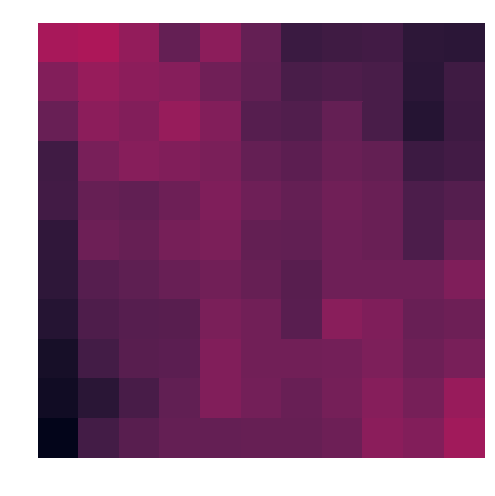

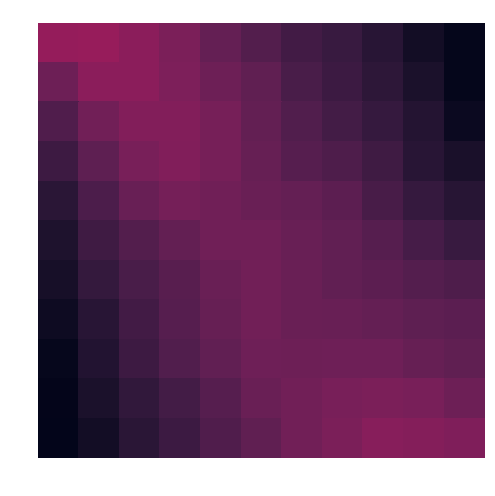

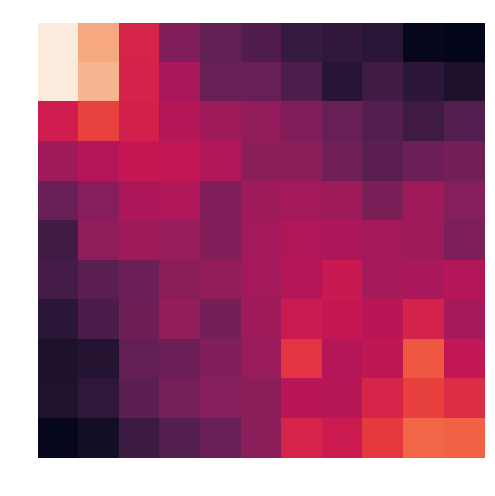

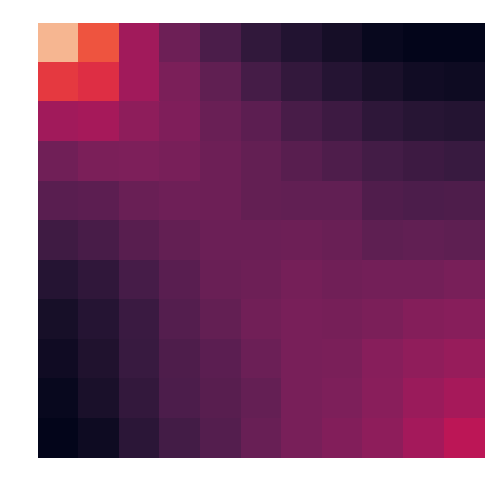

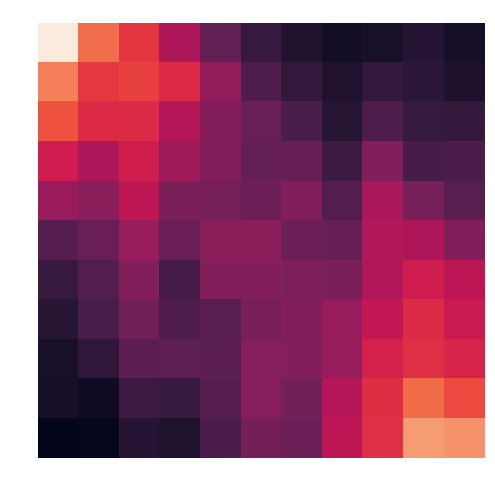

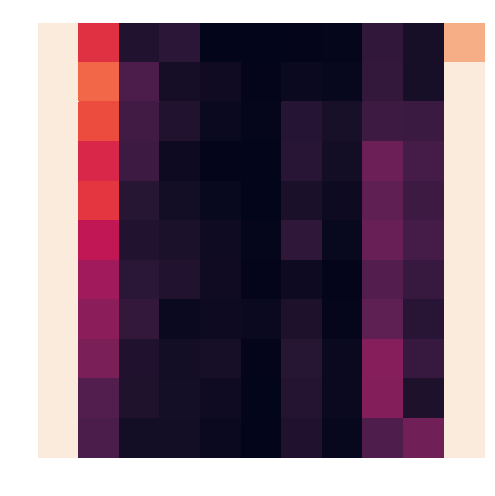

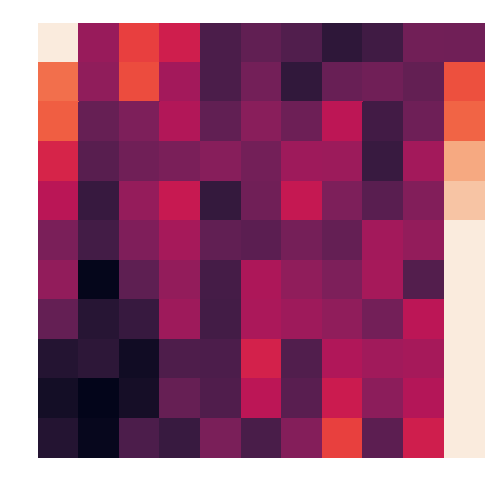

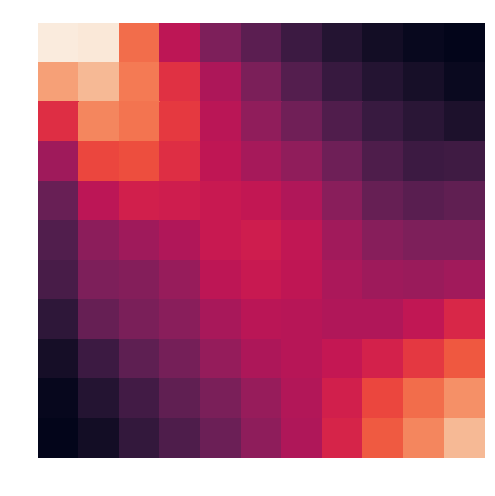

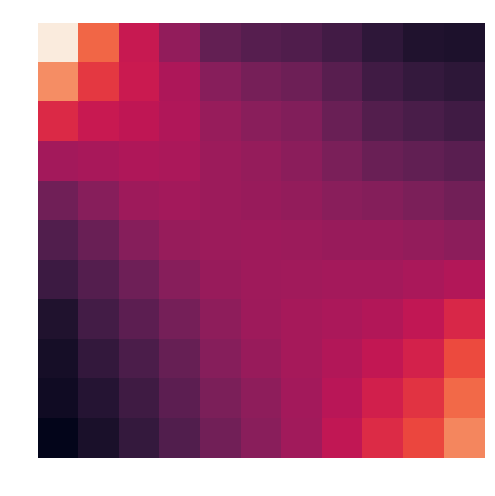

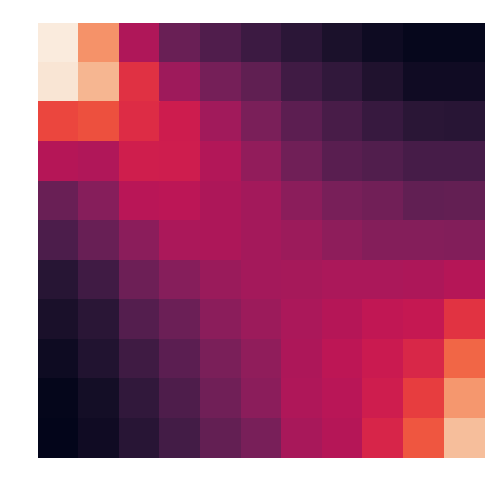

In [15]:
for clf, r in res.items():
    plt.figure(figsize=(8,8))
    r.proba_matrix(cbar=False, vmax= 18 if clf=='rbfSVM' else .2);
    plt.ylabel('Time')
    plt.xlabel('Predicted time')
    plt.title(clf)

In [77]:
from glob import glob

In [ ]:
glob

array(['knn', 'linSVM', 'rbfSVM', 'Decision_tree', 'Random_forest',
       'Neural_network', 'Naive_bayes', 'QDA', 'LDA',
       'Logistic_Regression', 'XGboost', 'LightGBM'], dtype=object)

In [29]:
res={}
for rat_label, df in zip(['sp_pfc', 'ez_pfc', 'ez_str'],
                         [sp_pfc,   ez_pfc,   ez_str]):
    params = pickle.load(open('data/results/hyperopt/XGboost/{}_dict_res.pickle'.format(rat_label),'rb'))['best_params']
    clf = XGBClassifier(**params, n_jobs=-1)
    res[rat_label] = shuffle_val_predict(clf, df, rat_label, feature_scaling='robust')

['sp_pfc']


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 's

['ez_pfc']


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 's

['ez_str']


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 's

In [19]:
from scipy.stats import pearsonr

In [20]:
def score_even(res):
    p = res.predictions
    p = p[p.group%2 == 0]
    return p.groupby('cv').apply(lambda S: pearsonr(S['true_label'], S['predictions_max'])[0])

In [37]:
resdf = res.res.apply(score_even).reset_index().melt(id_vars=['level_0','level_1','level_2'])
resdf.columns=['Classifier', 'Rat', 'Tuned', 'cv', 'Score (pearson r)']
resdf = resdf.sort_values('Score (pearson r)')

In [94]:
resdf['tunable'] = resdf.Classifier.apply(lambda s: len(glob('data/results/holdout_hyperopt/%s/*'%s))>0)
resdf=resdf[(resdf.Tuned==True)&(resdf.tunable==False) ==False]

In [39]:
clf_order = resdf.groupby('Classifier').mean().sort_values('Score (pearson r)').index.values

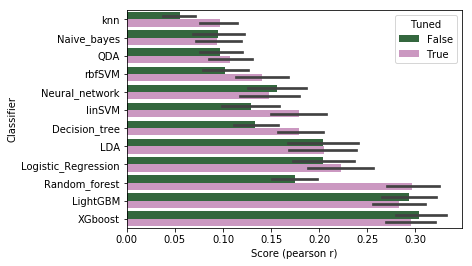

In [43]:
sns.barplot(y='Classifier', x='Score (pearson r)', hue='Tuned', data=resdf, order=clf_order, palette='cubehelix')
# plt.savefig('reports/figures/clf_comparison.png', dpi=160, bbox_inches='tight')

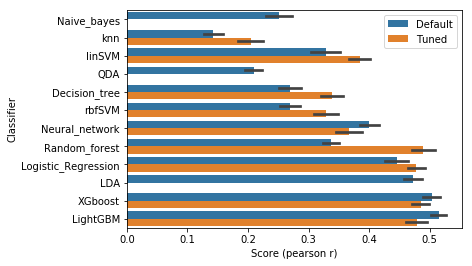

In [99]:
sns.barplot(y='Classifier', x='Score (pearson r)', hue='Tuned', data=resdf[resdf.Rat=='sp_pfc'])
l = plt.legend(loc='upper right')
l.get_texts()[0].set_text('Default')
l.get_texts()[1].set_text('Tuned')
plt.savefig('reports/figures/clf_comparison.png', dpi=200, bbox_inches='tight')

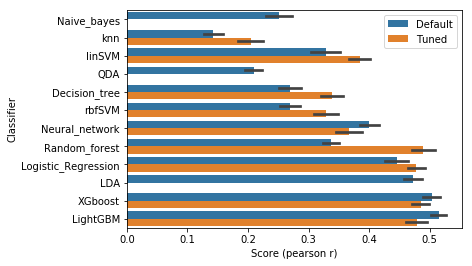

In [99]:
sns.barplot(y='Classifier', x='Score (pearson r)', hue='Tuned', data=resdf[resdf.Rat=='sp_pfc'])
l = plt.legend(loc='upper right')
l.get_texts()[0].set_text('Default')
l.get_texts()[1].set_text('Tuned')
plt.savefig('reports/figures/clf_comparison.png', dpi=200, bbox_inches='tight')

In [115]:
r = res.iloc[0].values[0]

In [124]:
times = pd.DataFrame(times, index=['Time(s)']).stack([0,1])[False].reset_index()
times.columns=['var', 'Classifier', 'Rat', 'Time(s)']

Text(0,0.5,'')

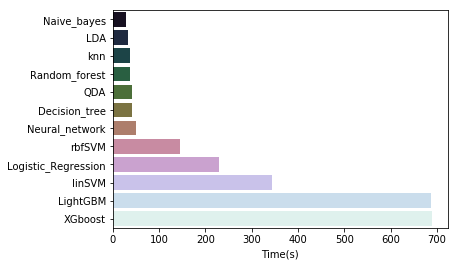

In [143]:
sns.barplot(data=times[times.Rat=='sp_pfc'].sort_values('Time(s)'), y='Classifier', x='Time(s)', palette='cubehelix')
plt.ylabel('')

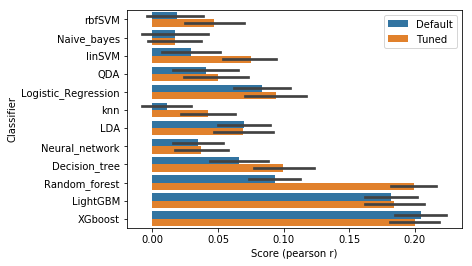

In [68]:
sns.barplot(y='Classifier', x='Score (pearson r)', hue='Tuned', data=resdf[resdf.Rat=='sp_pfc'])
# plt.savefig('reports/figures/clf_comparison.png', dpi=160, bbox_inches='tight')

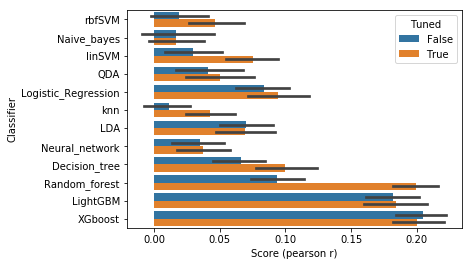

In [49]:
sns.barplot(y='Classifier', x='Score (pearson r)', hue='Tuned', data=resdf[resdf.Rat!='sp_pfc'])

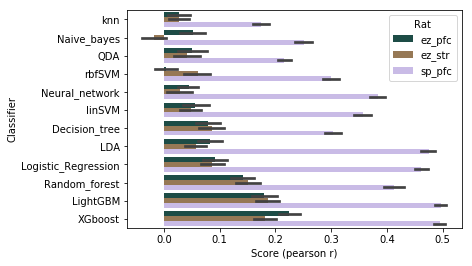

In [44]:
sns.barplot(y='Classifier', x='Score (pearson r)', hue='Rat', data=resdf, order=clf_order, palette='cubehelix')
# plt.savefig('reports/figures/clf_comparison.png', dpi=160, bbox_inches='tight')

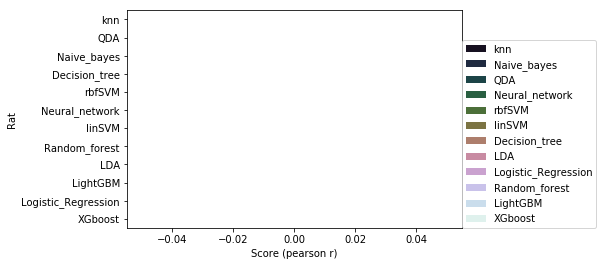

In [216]:
sns.barplot(y='Rat', hue='Classifier', x='Score (pearson r)', data=resdf, order=clf_order, palette='cubehelix')
plt.legend(loc=(1,0))
# plt.savefig('reports/figures/clf_comparison.png', dpi=160)

In [38]:
res['sp_pfc'].score.mean()['pearson_max']

0.5572299370656953

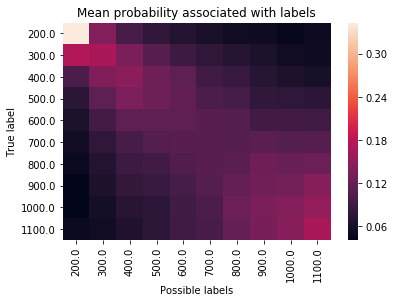

In [97]:
res['sp_pfc'].proba_matrix();

In [99]:
res['sp_pfc'].score.mean().pearson_max

0.5572299370656953

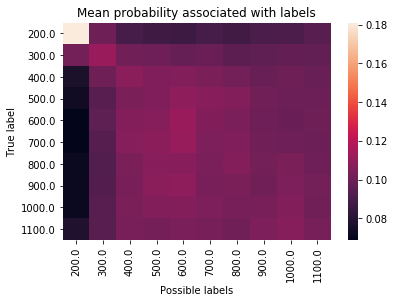

In [42]:
res['ez_str'].proba_matrix();

In [39]:
res['ez_pfc'].score.mean()['pearson_max']

0.27380787852659993

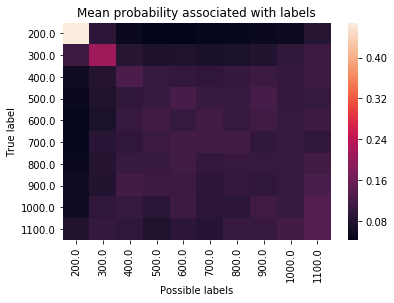

In [43]:
res['ez_pfc'].proba_matrix();

# Full

In [6]:
# Merging rats
DR = [io.load(label, 'wide_smoothed') for label in SHORTCUTS['groups']['DRRD']]
EZ = [io.load(label, 'wide_smoothed') for label in SHORTCUTS['groups']['EZ']]

sp_pfc = frankenstein(DR, _min_duration=1.5, is_selected=True, is_tired=False, subset='full')
sp_pfc = sp_pfc[(sp_pfc.reset_index('time').time>=200).values & (sp_pfc.reset_index('time').time<1300).values]

ez_pfc = frankenstein(EZ, _min_duration=1.5, _min_quality=0, area='PFC', subset='full')
ez_pfc = ez_pfc[(ez_pfc.reset_index('time').time>=200).values & (ez_pfc.reset_index('time').time<1300).values]

ez_str = frankenstein(EZ, _min_duration=1.5, _min_quality=0, area='STR', subset='full')
ez_str = ez_str[(ez_str.reset_index('time').time>=200).values & (ez_str.reset_index('time').time<1300).values]
merged_rats = [sp_pfc, ez_pfc, ez_str]

## XGBoost

In [65]:
resfull={}
for rat_label, df in zip(['sp_pfc', 'ez_pfc', 'ez_str'],
                         [sp_pfc,   ez_pfc,   ez_str]):
    params = pickle.load(open('data/results/hyperopt/XGboost/{}_dict_res.pickle'.format(rat_label),'rb'))['best_params']
    clf = XGBClassifier(**params, n_jobs=-1)
    resfull[rat_label] = shuffle_val_predict(clf, df, rat_label, feature_scaling='robust')

['sp_pfc']


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 's

['ez_pfc']


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 's

['ez_str']


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 's

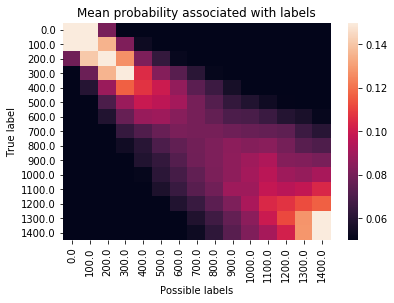

In [79]:
resfull['sp_pfc'].proba_matrix(vmin=.05,vmax=.15);

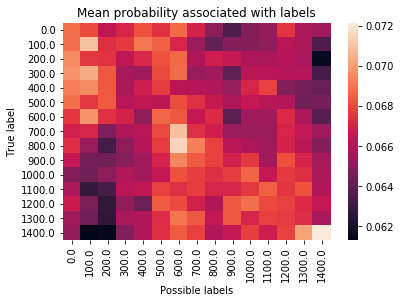

In [80]:
resfull['ez_str'].proba_matrix();

## Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_validate

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import cohen_kappa_score
from scipy.stats import pearsonr
pearson = lambda t, p: pearsonr(t, p)[0]

In [119]:
from catboost import CatBoostRegressor

In [125]:
%%time
ldares=pd.DataFrame()
scoring={'Explained Variance':'explained_variance', 
         "Pearson's r":make_scorer(pearson)}#, "Cohen's kappa":make_scorer(cohen_kappa_score)}
for rat_label, df in zip(['sp_pfc', 'ez_pfc', 'ez_str'],
                         [sp_pfc,   ez_pfc,   ez_str]):
    clf = BayesianRidge(verbose=False)
    local = pd.DataFrame(cross_validate(clf, df.values, df.reset_index().time, df.reset_index().trial, 
                                        cv = GroupShuffleSplit(3), scoring=scoring, return_train_score=False))
    local['rat'] = rat_label    
    ldares = ldares.append(local)

CPU times: user 9.37 s, sys: 15.7 s, total: 25 s
Wall time: 879 ms


In [126]:
res = ldares.filter(regex='test').rename(columns=lambda s: s[5:]).reset_index(drop=True).join(ldares.reset_index(drop=True).rat)

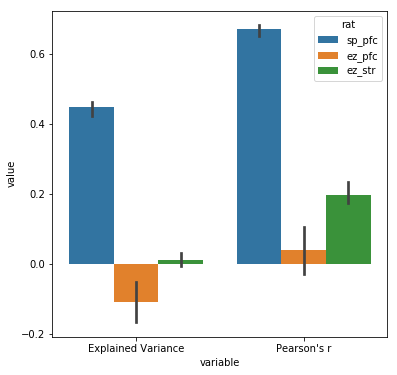

In [124]:
plt.figure(figsize=(6,6))
sns.barplot(data=res.melt('rat'), x='variable', y='value', hue='rat')

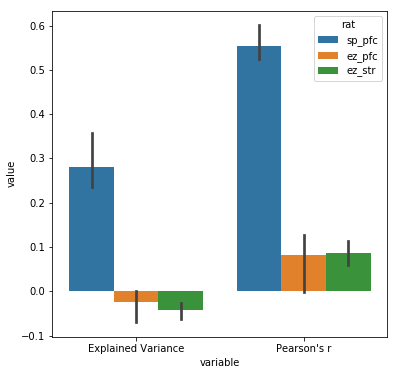

In [127]:
plt.figure(figsize=(6,6))
sns.barplot(data=res.melt('rat'), x='variable', y='value', hue='rat')

In [118]:
from sklearn.linear_model import ElasticNetCV, LarsCV, BayesianRidge

In [109]:
clv = BayesianRidge()
clv.fit(df.values, df.reset_index().time)
clv.score(df.values, df.reset_index().time)

0.14015028631657955

In [53]:
%%time
ldares=pd.DataFrame()
scoring={'Explained Variance':'explained_variance', "Pearson's r":make_scorer(pearson), "Cohen's kappa":make_scorer(cohen_kappa_score)}
for rat_label, df in zip(['sp_pfc', 'ez_pfc', 'ez_str'],
                         [sp_pfc,   ez_pfc,   ez_str]):
    clf = ()
    local = pd.DataFrame(cross_validate(clf, df.values, df.reset_index().time, df.reset_index().trial, 
                                        cv = GroupShuffleSplit(10), scoring=scoring, return_train_score=False))
    local['rat'] = rat_label    
    ldares = ldares.append(local)

CPU times: user 11.3 s, sys: 1.09 s, total: 12.4 s
Wall time: 645 ms


In [73]:
res = ldares.filter(regex='test').rename(columns=lambda s: s[5:]).reset_index(drop=True).join(ldares.reset_index(drop=True).rat)

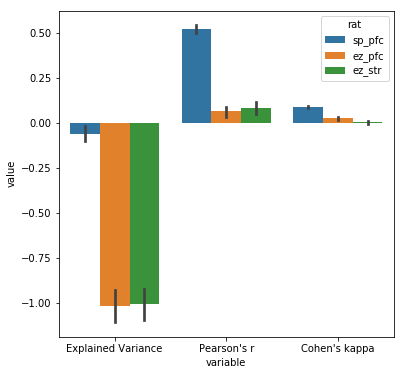

In [85]:
plt.figure(figsize=(6,6))
sns.barplot(data=res.melt('rat'), x='variable', y='value', hue='rat')

In [35]:
ldares

,fit_time,score_time,test_exp,test_pearsonr,test_kappa,rat
0,0.022785,0.004613,-0.106385,0.500603,0.098387,sp_pfc
1,0.023154,0.004566,-0.062470,0.528770,0.106452,sp_pfc
2,0.023101,0.004569,-0.016655,0.529207,0.101613,sp_pfc
3,0.023236,0.004560,-0.008627,0.564192,0.101613,sp_pfc
4,0.023355,0.004554,0.015558,0.539005,0.106452,sp_pfc
5,0.023497,0.004536,-0.086957,0.504830,0.058065,sp_pfc
6,0.042927,0.004599,0.058741,0.560403,0.101613,sp_pfc
7,0.024812,0.004583,-0.064314,0.520079,0.091935,sp_pfc
8,0.023179,0.004577,-0.137588,0.470635,0.083871,sp_pfc
9,0.022995,0.004544,-0.086048,0.501255,0.101613,sp_pfc


In [45]:
logfull={}
for rat_label, df in zip(['sp_pfc', 'ez_pfc', 'ez_str'],
                         [sp_pfc,   ez_pfc,   ez_str]):
    clf = LogisticRegression(C=1000)
    %time logfull[rat_label] = shuffle_val_predict(clf, df, rat_label, feature_scaling='robust')

['sp_pfc']


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 's

CPU times: user 27.4 s, sys: 397 ms, total: 27.8 s
Wall time: 27.8 s
['ez_pfc']


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 's

CPU times: user 5.02 s, sys: 130 ms, total: 5.15 s
Wall time: 5.1 s
['ez_str']


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 's

CPU times: user 9.12 s, sys: 172 ms, total: 9.29 s
Wall time: 9.24 s


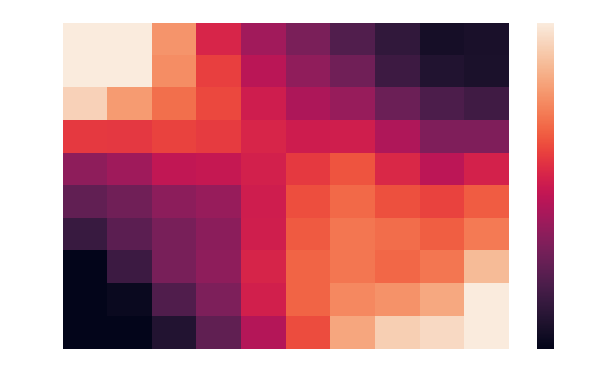

In [46]:
logfull['sp_pfc'].proba_matrix(vmin=.05,vmax=.15);

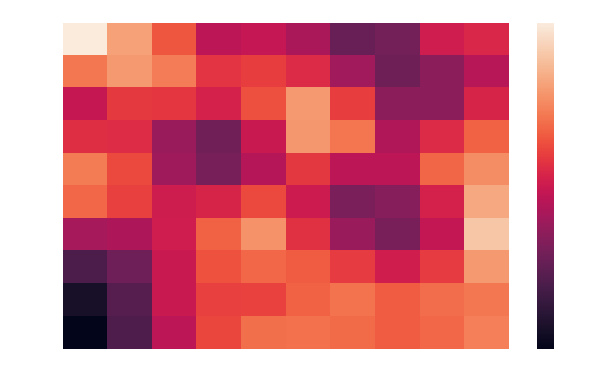

In [47]:
logfull['ez_str'].proba_matrix();

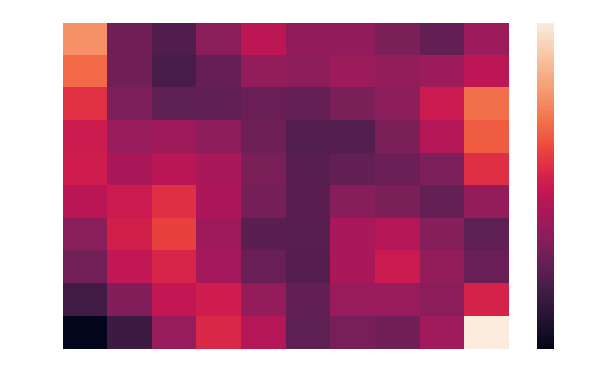

In [48]:
logfull['ez_pfc'].proba_matrix();

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [5]:
clf = LinearDiscriminantAnalysis()

# Learning curves

In [26]:
from spikelearn.models import shuffle_val_predict

In [ ]:
lcurve={}
ltimes={}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for size, clf, (df, name) in product([10, 15, 20, 30, 40, 55, 70, 90, 110, 140, 170, 210, 250, 300], makeClassifierList(), 
                                         zip([sp_pfc,ez_pfc,ez_str],['sp_pfc','ez_pfc','ez_str'])):
        print( '            ' , clf['name'], name)
        try:
            params = pickle.load(open('data/results/hyperopt/{}/sp_pfc_dict_res.pickle'.format(clf['name']),'rb'))['best_params']
            clf_func = clf['func'](**params)
        except:
            clf_func = clf['func']()
#         if clf['name'] not in ['XGBoost', 'LightGBM', 'linSVM']:
        counter = time.time()
        try:
            lcurve[(clf['name'], name, size)] = shuffle_val_predict(clf_func, df, 'name', 
                                                          feature_scaling='robust', n_splits=50, train_size=size)
            ltimes[(clf['name'], name, size)] = time.time()-counter
        except Exception as e:
            print(e)

             knn sp_pfc
['name']
             knn ez_pfc
['name']
             knn ez_str
['name']
             linSVM sp_pfc
['name']
             linSVM ez_pfc
['name']
             linSVM ez_str
['name']
             rbfSVM sp_pfc
['name']
             rbfSVM ez_pfc
['name']
             rbfSVM ez_str
['name']
             Decision_tree sp_pfc
['name']
             Decision_tree ez_pfc
['name']
             Decision_tree ez_str
['name']
             Random_forest sp_pfc
['name']
             Random_forest ez_pfc
['name']
             Random_forest ez_str
['name']
             Neural_network sp_pfc
['name']
             Neural_network ez_pfc
['name']
             Neural_network ez_str
['name']
             Naive_bayes sp_pfc
['name']
             Naive_bayes ez_pfc
['name']
             Naive_bayes ez_str
['name']
             QDA sp_pfc
['name']
             QDA ez_pfc
['name']
             QDA ez_str
['name']
             LDA sp_pfc
['name']
Classification metrics can't handle a mi

             LDA ez_str
['name']
             Logistic_Regression sp_pfc
['name']
             Logistic_Regression ez_pfc
['name']
             Logistic_Regression ez_str
['name']
             XGboost sp_pfc
['name']
             XGboost ez_pfc
['name']
             XGboost ez_str
['name']
             LightGBM sp_pfc
['name']
             LightGBM ez_pfc
['name']
             LightGBM ez_str
['name']
             knn sp_pfc
['name']
             knn ez_pfc
['name']
             knn ez_str
['name']
             linSVM sp_pfc
['name']
             linSVM ez_pfc
['name']
             linSVM ez_str
['name']
             rbfSVM sp_pfc
['name']
             rbfSVM ez_pfc
['name']
             rbfSVM ez_str
['name']
             Decision_tree sp_pfc
['name']
             Decision_tree ez_pfc
['name']
             Decision_tree ez_str
['name']
             Random_forest sp_pfc
['name']
             Random_forest ez_pfc
['name']
             Random_forest ez_str
['name']
             Neural_ne

In [28]:
pickle.dump(lcurve, open('data/results/holdout_hyperopt/learning_curves_2.pkl','wb'))

In [11]:
import pickle
import seaborn as sns

In [13]:
lcurve = pickle.load(open('data/results/holdout_hyperopt/learning_curves.pkl','rb'))

EOFError: Ran out of input

In [30]:
learning_scores = pd.DataFrame(lcurve, index=['res']).T.res.apply(lambda res: res.score.pearson_max)\
                        .reset_index().melt(id_vars=['level_0','level_1','level_2'])
learning_scores.columns = ['Classifier', 'Rat', 'Train Size', 'cv', 'score']

In [68]:
import matplotlib.pyplot as plt

In [37]:
learning_scores = learning_scores[learning_scores.Rat=='sp_pfc']

In [38]:
worst6 = learning_scores.groupby(['Train Size','Classifier']).mean().loc[210].score.sort_values()[:6].index.tolist()
worst6 = learning_scores[learning_scores.Classifier.isin(worst6)]
best6 = learning_scores.groupby(['Train Size','Classifier']).mean().loc[210].score.sort_values()[6:].index.tolist()
best6 = learning_scores[learning_scores.Classifier.isin(best6)]

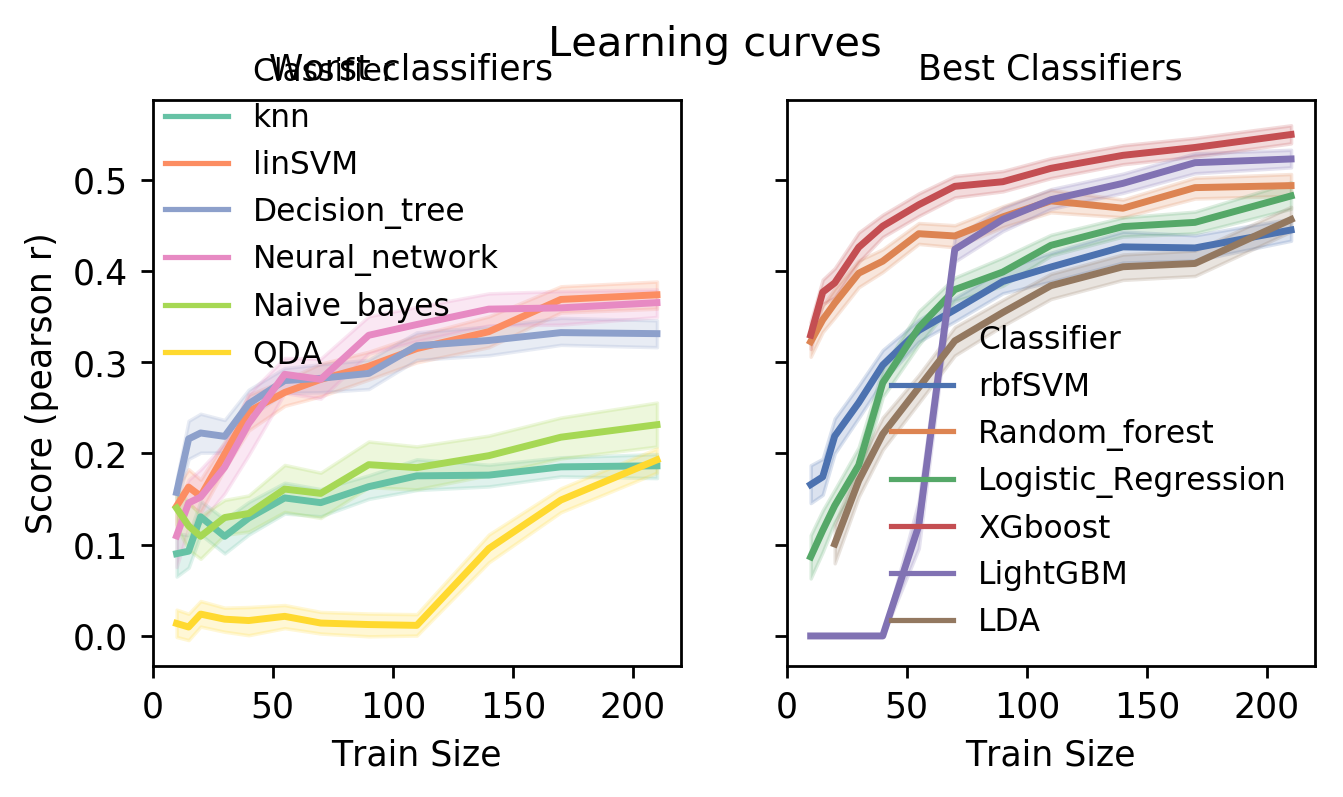

In [39]:
fig, ax = plt.subplots(1,2, dpi=250, sharey=True, figsize=(6,3))
sns.lineplot(x='Train Size', y='score', hue='Classifier', data=worst6, palette='Set2', ax=ax[0], linewidth=2)
sns.lineplot(x='Train Size', y='score', hue='Classifier', data=best6, palette='deep', ax=ax[1], linewidth=2)
ax[0].legend(frameon=False, loc=(0,.5), fontsize=9)
ax[1].legend(frameon=False, loc='lower right', fontsize=9)
ax[0].set_title('Worst classifiers ', fontsize=10)
ax[1].set_title('Best Classifiers', fontsize=10)
plt.suptitle('Learning curves')
ax[0].set_ylabel('Score (pearson r)')
plt.savefig('reports/figures/models/Learning curves/learning_curves_sppfc.png', dpi=150, bbox_inches='tight')
plt.savefig('reports/figures/models/Learning curves/learning_curves_sppfc.eps', bbox_inches='tight')

In [33]:
import matplotlib.pyplot as plt

In [41]:
%run ../../ConvTech/ConvTech/black.ipynb

In [40]:
import matplotlib as mpl
mpl.cont

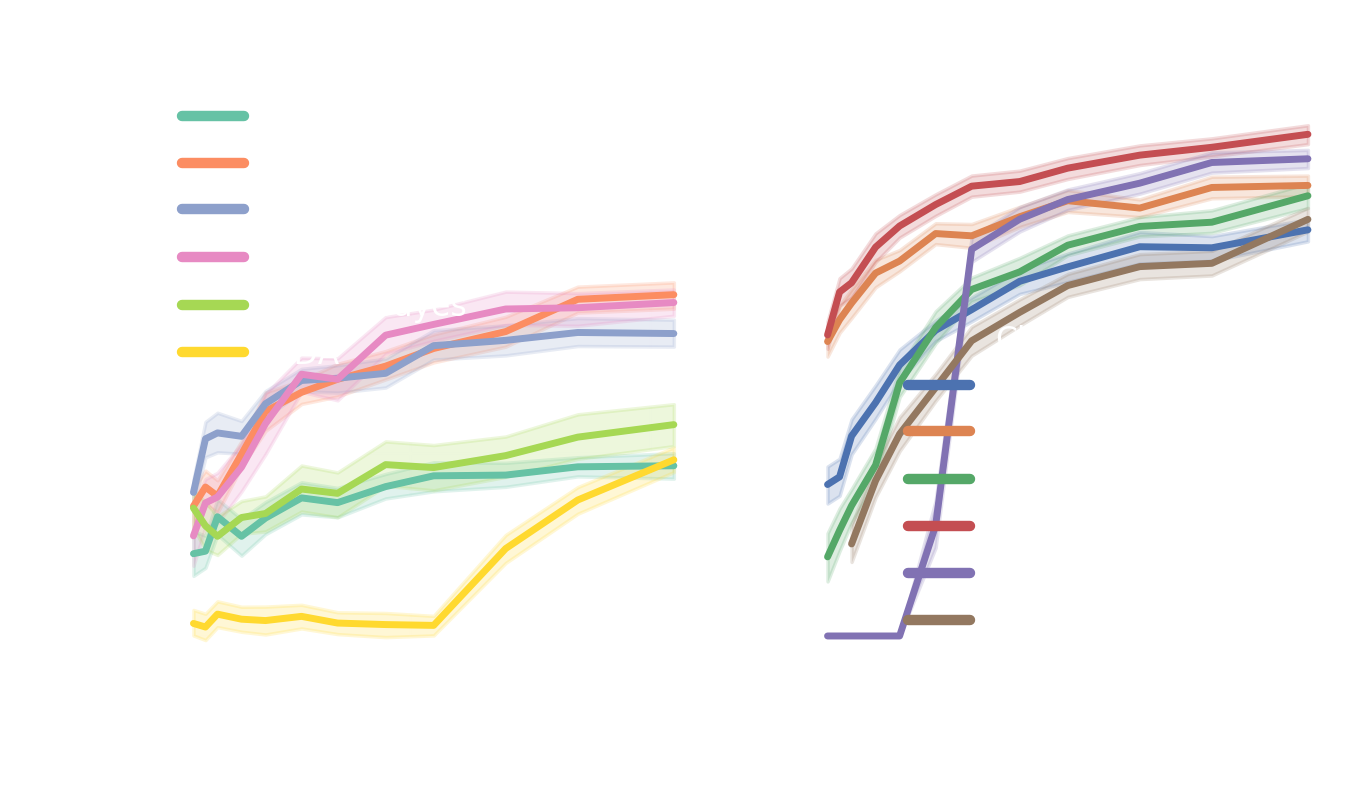

In [45]:
fig, ax = plt.subplots(1,2, dpi=250, sharey=True, figsize=(6,3))
sns.lineplot(x='Train Size', y='score', hue='Classifier', data=worst6, palette='Set2', ax=ax[0], linewidth=2)
sns.lineplot(x='Train Size', y='score', hue='Classifier', data=best6, palette='deep', ax=ax[1], linewidth=2)
ax[0].legend(frameon=False, loc=(0,.5), fontsize=9)
ax[1].legend(frameon=False, loc='lower right', fontsize=9)
# ax[0].set_title('Worst classifiers ', fontsize=10)
# ax[1].set_title('Best Classifiers', fontsize=10)
plt.suptitle('Learning curves')
ax[0].set_ylabel('Score (pearson r)')
plt.savefig('reports/figures/models/Learning curves/learning_curves_sppfc_white.png', dpi=150, bbox_inches='tight', transparent=True)
plt.savefig('reports/figures/models/Learning curves/learning_curves_sppfc_white.eps', bbox_inches='tight', transparent=True)

# Baseline

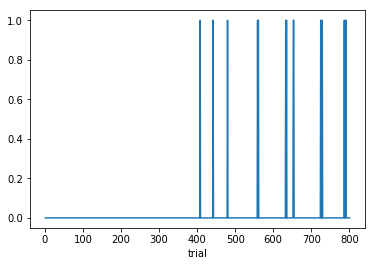

In [5]:

bs = io.load('DRRD 8', 'behav_stats')
(bs.intertrial_interval>60).astype(int).plot()

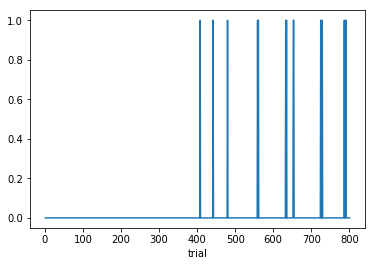

In [6]:
baseline = io.load('DRRD 8', 'baseline').applymap(lambda l: np.histogram(l, bins=5, range=(-.5, 0))[0]).apply(lambda S: np.hstack(S), axis=1)
bs = io.load('DRRD 8', 'behav_stats')
(bs.intertrial_interval>60).astype(int).plot()

In [108]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

In [245]:
baseline = io.load('DRRD 8', 'baseline')\
            .applymap(lambda l: np.histogram(l, bins=5, range=(-.5, 0))[0])\
            .apply(lambda S: np.hstack(S), axis=1)

bs = select(io.load('DRRD 8', 'behav_stats'), _max_duration=3, is_tired=False)

In [246]:
X = baseline[np.isin(baseline.index.values,bs.index.values)]
y = bs[np.isin(bs.index.values, baseline.index.values)].duration> .6

In [247]:
from catboost import CatBoostClassifier

In [248]:
from sklearn.linear_model import LogisticRegressionCV

In [249]:
clf = make_pipeline(StandardScaler(),
                    LogisticRegressionCV(verbose=False))

In [250]:
res = cross_validate(clf, np.vstack(X.values).astype(float), y, scoring={'f1':'f1', 'acc':'accuracy'}, 
                     cv=10, return_train_score=True)

In [254]:
y.value_counts(True)

True     0.86941
False    0.13059
Name: duration, dtype: float64

In [255]:
res['test_acc'].mean()

0.8694856459330144

---